In [1]:
!pip install -q keras==2.4.0
!pip install -q tensorflow==2.4.0
#pip install -U scikit-image==0.16.2
!pip install -q pycocotools

# Library to silence Tensorflow logs
!pip install -q silence-tensorflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
tfx-bsl 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tfx-bsl 1.5.0 requires pyarrow<6,>=1, but you have pyarrow 6.0.1 which is incompatible.
tfx-bsl 1.5.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,<3,>=1.15.2, but you have tensorflow 2.5.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-transform 1.5.0 requires pyarrow<6,>=1, but you 

In [2]:
import sys
sys.path.append('../input/sartorius-instance-segmentation/sartorius-maskrcnn/sartorius-maskrcnn/Mask_RCNN')
sys.path.append('../input/sartorius-helper-package')

import silence_tensorflow.auto

In [3]:
import matplotlib.pyplot as plt
import mrcnn.utils as utils
import mrcnn.model as modellib
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

import os
import sys
import json
import time
import skimage
import imageio
import glob
import multiprocessing
import cv2
import imgaug.augmenters as iaa
import imgaug as ia

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from PIL import Image, ImageEnhance
from mrcnn.config import Config
from mrcnn import visualize

from livecell_dataset import LiveCell_Dataset

# ignore warnings to make outputs clearer
import warnings
warnings.filterwarnings('ignore')

seed=31
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print('Import successfully')
print('Keras version: {}\nTensoflow version: {}\nTensorflow keras version: {}'
      .format(keras.__version__, tf.__version__, tf.keras.__version__))

Using TensorFlow backend.


Import successfully
Keras version: 2.4.0
Tensoflow version: 2.4.0
Tensorflow keras version: 2.4.0


## <font color='green'/> **Train Configuration**

In [4]:
# Original Image Dimensions
HEIGHT = 520
WIDTH = 704
SHAPE = (HEIGHT, WIDTH)

# Target image dimension which are divisable by 64 as required by the Mask-RCNN model
HEIGHT_TARGET = 64 * 9  # = 576
WIDTH_TARGET = 64 * 11  # = 704
SHAPE_TARGET = (HEIGHT_TARGET, WIDTH_TARGET)

BATCH_SIZE = 1
EPOCHS_ALL = 10
INITIAL_EPOCH = 0
PRED_FOREGROUND = False

## <font color='green'/> **Helper function**

In [5]:
def rle_decode_by_image_id(image_id):
    rows = train.loc[train['id'] == image_id]
    
    # Image shape
    mask = np.full(shape=[len(rows), np.prod(SHAPE)], fill_value=0, dtype=np.uint8)
    
    for idx, (_, row) in enumerate(rows.iterrows()):
        s = row['annotation'].split()
        starts, lengths = [np.array(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            mask[idx, lo:hi] = True
        
    mask = mask.reshape([len(rows), *SHAPE])
    mask = np.moveaxis(mask, 0, 2)
    
    return mask

# Func. to pad images and masks
def pad_image(image, constant_values):
    pad_h = (HEIGHT_TARGET - HEIGHT) // 2
    pad_w = (WIDTH_TARGET - WIDTH) // 2
    
    if len(image.shape) == 3:
        return np.pad(image, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), constant_values=constant_values)
    else:
        return np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), constant_values=constant_values)
    
# Removes the padding from an image
def unpad_image(image):
    offset_h = (HEIGHT_TARGET - HEIGHT) // 2
    offset_w = (WIDTH_TARGET - WIDTH) // 2
    
    return image[offset_h:offset_h+HEIGHT, offset_w:offset_w+WIDTH]

# Run Length Encode an instance
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    #img = unpad_image(img)
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# <font color='brown'/> **Prepare Dataset**

In [6]:
train = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')

# Drop cols
train = train.drop(['plate_time', 'sample_date', 'sample_id', 
                    'elapsed_timedelta', 'height', 'width'], axis = 1)

In [7]:
# Unique Image IDs
id_unique = train['id'].unique()

# Original Image File Path
def get_file_path(image_id):
    return '../input/sartorius-cell-instance-segmentation/train/{}.png'.format(image_id)

train['file_path'] = train['id'].apply(get_file_path)

# Unique Cell Names
CELL_NAMES = np.sort(train['cell_type'].unique())
print('CELL_NAMES: {}'.format(CELL_NAMES))

# Cell type to label dictionary
CELL_NAMES_DICT = dict([(v, k) for k, v in enumerate(CELL_NAMES)])
print('CELL_NAMES_DICT: {}'.format(CELL_NAMES_DICT))

# Add cell type label to train, "+1" because label 0 is reserved for background
train['cell_type_label'] = train['cell_type'].apply(CELL_NAMES_DICT.get) + 1

# Image ID to cell type label dictionary
ID2CELL_LABEL = dict(
    [(k, v) for k, v in train[['id', 'cell_type_label']].itertuples(name=None, index=False)]
)

CELL_NAMES: ['astro' 'cort' 'shsy5y']
CELL_NAMES_DICT: {'astro': 0, 'cort': 1, 'shsy5y': 2}


In [8]:
# Split to train and validation dataset
from sklearn.model_selection import train_test_split
train_id_unique, val_id_unique = train_test_split(id_unique, test_size=0.2, shuffle=True, random_state=42)

assert (len(train_id_unique) + len(val_id_unique)) == len(id_unique)

print('Num of images in train dataset: {}'.format(len(train_id_unique)))
print('Num of images in val dataset: {}'.format(len(val_id_unique)))

Num of images in train dataset: 484
Num of images in val dataset: 122


In [9]:
id_unique = train['id'].unique()
image_id2file_path = train.groupby('id')[['id', 'file_path']].head(1)
image_id2file_path = image_id2file_path.set_index('id').squeeze().to_dict()

## <font color='green'/>**Split to train and val set**

In [10]:
!rm -rf ./train ./test ./val
!mkdir ./train ./test ./val

In [11]:
id_unique = train['id'].unique()
    
def copy_img_to_working_dir(image_ids, is_val_set=False):
    """
    Create padded training samples with enhanced contrast
    Agrs:
        image_ids: List of image_id
        is_val_set: Flag to copy img to validation dir
    """
    
    image_group = 'val' if is_val_set else 'train'
    for image_id in tqdm(image_ids):
        # Read original image
        image = imageio.imread(image_id2file_path[image_id])
    
        # Pad image
        image = pad_image(image, 128)
    
        # Save image in working dir., required for Mask-RCNN
        imageio.imwrite('./{}/{}.png'.format(image_group, image_id), image)

copy_img_to_working_dir(train_id_unique)
copy_img_to_working_dir(val_id_unique, True)

  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

## <font color='green'/>**Dataset**

Create a synthetic dataset

Extend the Dataset class and add a method to load the dataset, `load_data()`, and override `load_mask()` method:

In [12]:
class CellDataset(utils.Dataset):
    def __init__(self, pred_fg=True):
        super().__init__()
    
    def load_data(self,image_ids, image_group):  
        # Add class
        [self.add_class('cell', i+1, name) for i, name in enumerate(CELL_NAMES)]
        
        # Add image
        for idx, image_id in enumerate(tqdm(image_ids)):            
            label = ID2CELL_LABEL[image_id]
            
            self.add_image('cell', image_id=image_id, 
                            path='./{}/{}.png'.format(image_group, image_id), 
                            label=label)   
                    
    def load_mask(self, image_id):
        """
        Load instance masks for the given image.
        Mask-RCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for.
        Return:
            masks: A bool array of shape [height, width, instance count] with 
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        
        info = self.image_info[image_id]
        image_id = info['id']
        
        # Get masks by image_id
        masks = rle_decode_by_image_id(image_id)
        masks = pad_image(masks, 0)
        
        # Get label
        _, _, size = masks.shape
        label = info['label']
        class_ids = np.full(size, label, dtype=np.int32)
        
        return masks, class_ids

In [13]:
# Create training dataset
dataset_train = CellDataset()
dataset_train.load_data(train_id_unique, 'train')
dataset_train.prepare()

# Create validation dataset
dataset_val = CellDataset()
dataset_val.load_data(val_id_unique, 'val')
dataset_val.prepare()

  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

# <font color='brown'/> **Prepare model**

In [14]:
class CellConfig(Config):
    """
    Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides value specific
    to the cigaratte butts dataset.
    """

    NAME = 'l2reg-and-head'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = BATCH_SIZE
    STEPS_PER_EPOCH = int(dataset_train.num_images / BATCH_SIZE)
    VALIDATION_STEPS = int(dataset_val.num_images / BATCH_SIZE)
    
    # No. classes
    NUM_CLASSES = 2 if PRED_FOREGROUND else 1 + len(CELL_NAMES)
    
    # Image dimensions
    IMAGE_RESIZE_MODE = "none"
    IMAGE_MIN_DIM = HEIGHT_TARGET
    IMAGE_MAX_DIM = WIDTH_TARGET
    IMAGE_SHAPE = [HEIGHT_TARGET, WIDTH_TARGET, 3]
    
    # Dont train Batch Normalization because of small batch size
    # There are too few samples to correctly train the normalization
    TRAIN_BN = False
    
    # Learing rate
    LEARNING_RATE = 0.0001
    #\N_WARMUP_STEPS = 2
    #LR_SCHEDULE = True
    
    # Weight decay regularization
    WEIGHT_DECAY = 10
    
    # Mini mask
    USE_MINI_MASK = False
    
    MAX_QUEUE_SIZE = 40
    
    INITIAL_EPOCH = INITIAL_EPOCH
    
config = CellConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  704
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  576
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [576 704   3]
INITIAL_EPOCH                  0
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE           

## <font color='green'/>**Create Model**

In [15]:
# Create model in training mode
!mkdir ./model_checkpoints
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./model_checkpoints')

In [16]:
!mkdir ./COCO
#init_with = 'coco'
init_with = '../input/sartorius-weight/27_04_22/27_04_22/mask_rcnn_270422-all-7th-train_0055.h5'

if init_with == 'coco':
    # path to COCO-dataset-weights
    COCO_MODEL_PATH = './COCO/coco.h5'

    # download COCO trained weights from Releases if needed
    if not os.path.exists(COCO_MODEL_PATH):
        utils.download_trained_weights(COCO_MODEL_PATH)

    # Load COCO pretrained weights
    exclude = ["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
    model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=exclude)

elif init_with == 'last':
    file_path = model.find_last()
    print(f'Loading weights from: {file_path}')
    model.load_weights(file_path, by_name=True)
    
else:
    print(f'Loading weights from: {init_with}')
    model.load_weights(init_with, by_name=False)

Loading weights from: ../input/sartorius-weight/27_04_22/27_04_22/mask_rcnn_270422-all-7th-train_0055.h5


## <font color='green'/> **Training Model**

Only train the head layers, freezing all the backbone layers in the 1st train

In [17]:
def init_augmentation():
    aug_seq = iaa.Sequential([
        iaa.Crop(percent=(0.05, 0.11)),
        #iaa.Fliplr(0.65),
        #iaa.Flipud(0.65),
        #iaa.Affine(rotate=ia.random.RNG(None).uniform(5, 16))
        iaa.AdditiveGaussianNoise(scale=(5, 20))
    ])
    
    return aug_seq

augmentation = init_augmentation()

In [18]:
start_train = time.time()

history = model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, 
                      epochs=EPOCHS_ALL, layers="heads", augmentation=augmentation)

end_train = time.time()
hours = round((end_train - start_train) / (60 * 60), 2)


Starting at epoch 0. LR=0.0001

Checkpoint Path: ./model_checkpoints/l2reg-and-head20220624T0330/mask_rcnn_l2reg-and-head_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_

In [19]:
print(f'Training MRCNN by {config.BACKBONE} backbone ' + 
      f'over {EPOCHS_ALL - INITIAL_EPOCH} took {hours} hours')

Training MRCNN by resnet101 backbone over 10 took 3.13 hours


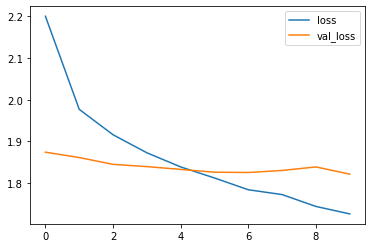

In [20]:
hist_df = pd.DataFrame(history.history)
hist_df.loc[:, ['loss', 'val_loss']].plot()
plt.show()

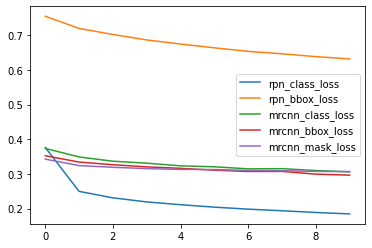

In [21]:
hist_df.loc[:, ['rpn_class_loss', 'rpn_bbox_loss', 'mrcnn_class_loss',
                'mrcnn_bbox_loss', 'mrcnn_mask_loss']].plot()
plt.show()

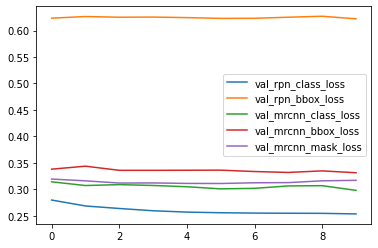

In [22]:
hist_df.loc[:, ['val_rpn_class_loss', 'val_rpn_bbox_loss', 'val_mrcnn_class_loss',
                'val_mrcnn_bbox_loss', 'val_mrcnn_mask_loss']].plot()
plt.show()

## <font color='green'/> **Inference**

In [23]:
class InferenceConfig(Config):
    
    NAME = 'l2reg-and-head'
    
    # Set batch size to 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # No. classes
    NUM_CLASSES = 2 if PRED_FOREGROUND else 1 + len(CELL_NAMES)
    
    # Image dimensions
    IMAGE_RESIZE_MODE = "none"
    IMAGE_MIN_DIM = HEIGHT_TARGET
    IMAGE_MAX_DIM = WIDTH_TARGET
    IMAGE_SHAPE = [HEIGHT_TARGET, WIDTH_TARGET, 3]
        
    # Mini mask
    USE_MINI_MASK = False

infer_config = InferenceConfig()

In [24]:
# Create model in inference mode
model = modellib.MaskRCNN(mode="inference", config=infer_config, model_dir='./model_checkpoints')

# Load weight
file_path = model.find_last()
#file_path = '../input/sartorius-weight/05_04_22/05_04_22/mask_rcnn_kaggle_sartorius_cfg_0006.h5'
print(f'Loading weights from: {file_path}')
model.load_weights(file_path, by_name=True)

Loading weights from: ./model_checkpoints/l2reg-and-head20220624T0330/mask_rcnn_l2reg-and-head_0010.h5
Re-starting from epoch 10


original_image           shape: (576, 704, 3)         min:    3.00000  max:  251.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  704.00000  int64
gt_class_id              shape: (29,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (29, 4)               min:    1.00000  max:  704.00000  int32
gt_mask                  shape: (576, 704, 29)        min:    0.00000  max:    1.00000  uint8


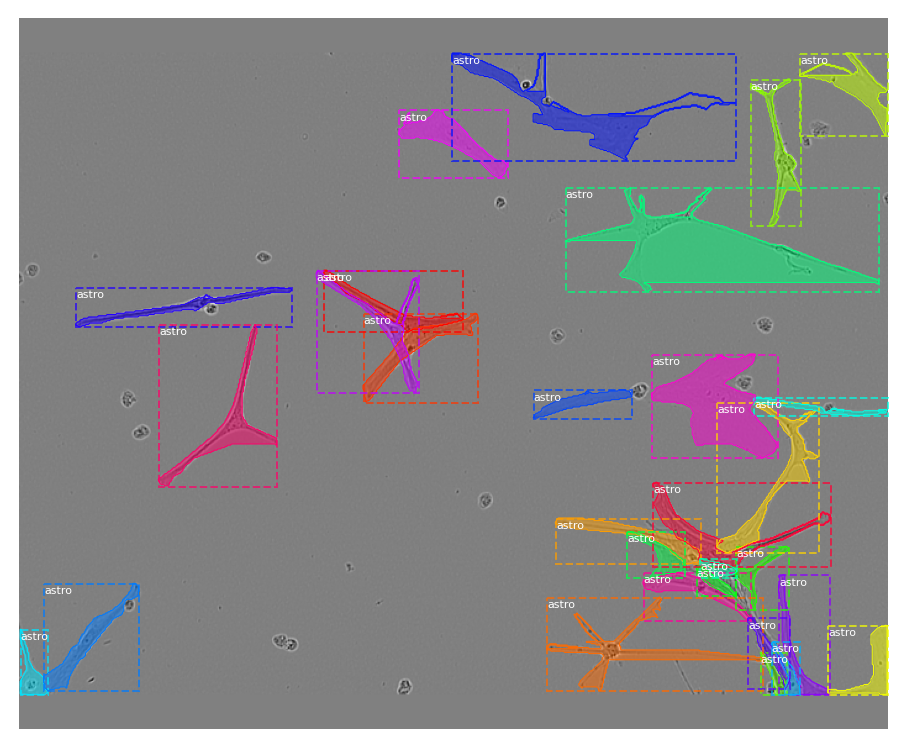

In [25]:
from mrcnn.model import log

# Test on a random image
image_id = np.random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, infer_config, image_id)

log('original_image', original_image)
log('image_meta', image_meta)
log('gt_class_id', gt_class_id)
log('gt_bbox', gt_bbox)
log('gt_mask', gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                           dataset_train.class_names)

Processing 1 images
image                    shape: (576, 704, 3)         min:    3.00000  max:  251.00000  uint8
molded_images            shape: (1, 576, 704, 3)      min: -120.70000  max:  147.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  704.00000  int64
anchors                  shape: (1, 101277, 4)        min:   -0.62963  max:    1.51833  float32


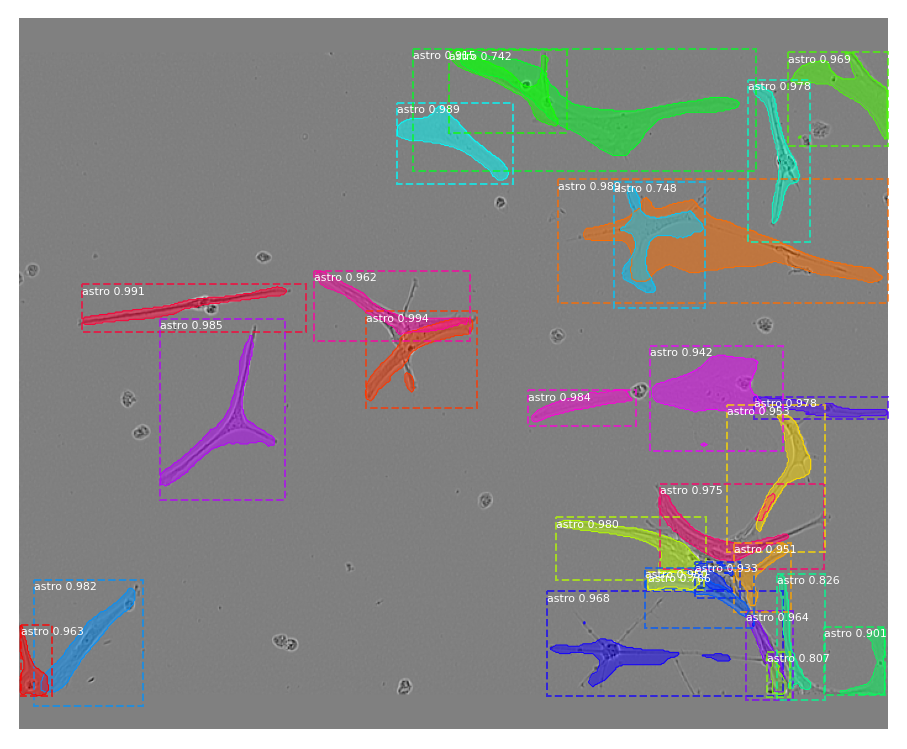

In [26]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                           dataset_train.class_names, r['scores'])

<a href='./model_checkpoints/l2reg-and-head20220619T0338/mask_rcnn_l2reg-and-head_0010.h5'/>Download file weight